In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
from time import time
# 3p
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpe
import scipy
# project
from rpca import pcp

## demo

We are going to use the 3rd video from the **BMC 2012 Background Models Challenge Dataset** for background removal. The idea is to stack all the frames of the video as columns of a matrix M, and then apply RPCA to extract L and S. In our case, the low-rank component L naturally corresponds to the stationary background and the sparse component S captures the anomalies,i.e the moving foreground.

First we import the video and extract the frames in order to create the matrix M. 

In [3]:
video = mpe.VideoFileClip("demo_videos/Video_003.avi");
def rgb2gray(rgb): return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
M = np.vstack([scipy.misc.imresize(rgb2gray(video.get_frame(i/float(100))).astype(int), (60, 80)).flatten() for i in range(4 * int(video.duration))]).T
M.shape

(4800, 452)

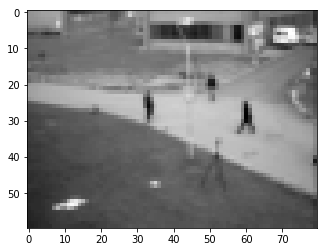

In [4]:
dims = (60, 80)
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

### First try with PCA

In [5]:
from sklearn import decomposition
since = time()
u, s, v = decomposition.randomized_svd(M, 2)
print(f'took {round(time() - since, 2)} s')
low_rank = u @ np.diag(s) @ v

took 0.17 s


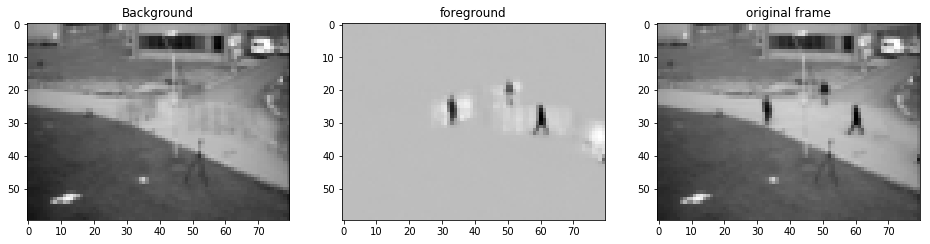

In [6]:
fig , axs = plt.subplots(1, 3, figsize=(16,10))
frame = 140
axs[0].imshow(np.reshape(low_rank[:,frame], dims), cmap='gray');
axs[0].set_title("Background")
axs[1].imshow(np.reshape(M[:,frame] - low_rank[:,frame], dims), cmap='gray');
axs[1].set_title("foreground");
axs[2].imshow(np.reshape(M[:,frame], dims), cmap='gray');
axs[2].set_title("original frame");

### And with RPCA ...

In [8]:
L, S = pcp(M, maxiter=10)

Convergence Not reached! Took 2.01 s


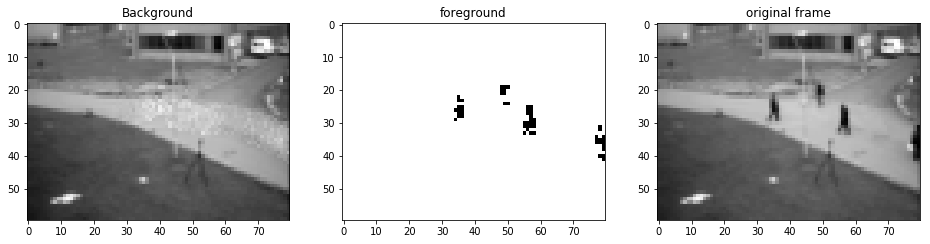

In [9]:
fig , axs = plt.subplots(1, 3, figsize=(16,10))
frame = 180
axs[0].imshow(np.reshape(L[:,frame], dims), cmap='gray');
axs[0].set_title("Background")
axs[1].imshow(np.reshape(S[:,frame], dims), cmap='gray');
axs[1].set_title("foreground");
axs[2].imshow(np.reshape(M[:,frame], dims), cmap='gray');
axs[2].set_title("original frame");

#### Let's create a video of it

In [10]:
video_array = np.concatenate([M.T.reshape(-1, 60, 80), S.T.reshape(-1, 60, 80), L.T.reshape(-1, 60, 80)], axis=-1)